# 1.この課題の目的
発展的なRNNの手法を理解する
以下の要件をすべて満たしていた場合、合格とします。

※Jupyter Notebookを使い課題に沿った検証や説明ができている。

# 2.KerasのRecurrentレイヤー
Kerasには複数のRecurrentレイヤーが用意されています。今回のSprintではこれら全てを動かし、それらを理解し区別できる状態を目指します。

以下のドキュメントにまとめられています。

[Recurrentレイヤー - Keras Documentation](https://keras.io/ja/layers/recurrent/)

次の11個の項目があります。

- RNN
- SimpleRNN
- GRU
- LSTM
- ConvLSTM2D
- SimpleRNNCell
- GRUCell
- LSTMCell
- StackedRNNCells
- CuDNNGRU
- CuDNNLSTM

# 【問題1】各種手法の実行
Keras公式のサンプルをスタートコードとします。これを元に、上記11個の項目全てを使用してください。

例えばこの中でSimpleRNNとLSTMなどは並列関係であり、精度の比較が行えます。そういった関係を見つけて比較をしてください。

なおConvLSTM2Dのみ2次元配列を受け付ける手法であり、他と単純な精度の比較はできません。

LSTMのサンプルコード

[keras/imdb_lstm.py at master · keras-team/keras](https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py)

ConvLSTM2Dのサンプルコード

[keras/conv_lstm.py at master · keras-team/keras](https://github.com/keras-team/keras/blob/master/examples/conv_lstm.py)

このサンプルコードをそのまま使う必要はなく、ノード数やエポックなどは変更して構いません。全て実行する上での実行時間を考慮した数に設定してください。

## 実行環境
- Google ColaboratoryにてGPU(Tesla K80)を使用
- バッチサイズ・エポック数、共に5で実行しモデル作成〜学習〜予測までの実行時間を計測
- 実行時間の短縮の為、学習データ・検証データ・テストデータは全て先頭から100個のデータのみを使用
- コード実行時のERR回避の為、NumpyのVerを1.16.1に変更して実行

## コード実行時のERR回避の為、NumpyのVerを1.16.1にする
- ValueError: Object arrays cannot be loaded when allow_pickle=False
- Numpy 1.16.1から1.16.3になる際にallow_pickle=Falseがデフォルトになった為

In [1]:
!pip install numpy==1.16.1

     |████████████████████████████████| 17.3MB 3.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4


In [1]:
import numpy as np

print(np.__version__)

1.16.1


## 使用するクラスのインポート

In [2]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.datasets import imdb
from keras.layers import RNN,SimpleRNN ,SimpleRNNCell, GRU, LSTM, GRUCell, LSTMCell, \
                                        CuDNNLSTM, CuDNNGRU, CuDNNLSTM
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


## データの読み込み

In [3]:
max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


## 各モデルの実行速度及び精度を保存する辞書を作成

In [0]:
time_dict = {}
test_acc_dict = {}

## バッチサイズ、エポック数を指定

In [0]:
batch_size = 5
n_epoch = 5

## RNN→LSTMモデルのサンプルコードの書き換えで動作
- RNNレイヤーは引数にcellクラスのインスタンスを渡す事で動作する為、今回はSimpleRNNCellのインスタンスを引数に設定する事で動作を確認
```python
cell = SimpleRNNCell(128, dropout=0.2, recurrent_dropout=0.2)
```

In [6]:
start = time.time()

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
cell = SimpleRNNCell(128, dropout=0.2, recurrent_dropout=0.2)
model.add(RNN(cell))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train[:100], y_train[:100],
          batch_size=batch_size,
          epochs=n_epoch,
          validation_data=(x_test[:100], y_test[:100]))
score, acc = model.evaluate(x_test[:100], y_test[:100],
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

test_acc_dict['RNN'] = acc
time_dict['RNN'] = elapsed_time

W0727 09:38:54.048186 140084525143936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 09:38:54.087035 140084525143936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 09:38:54.092929 140084525143936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 09:38:54.145067 140084525143936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0727 09:38:54.154560 

Build model...


W0727 09:38:54.263088 140084525143936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0727 09:38:54.282793 140084525143936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0727 09:38:54.288880 140084525143936 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train...
Train on 100 samples, validate on 100 samples
Epoch 1/5
100/100 [==============================] - 5s 50ms/step - loss: 0.7302 - acc: 0.5400 - val_loss: 0.6966 - val_acc: 0.5200
Epoch 2/5
100/100 [==============================] - 1s 8ms/step - loss: 0.6885 - acc: 0.5300 - val_loss: 0.7175 - val_acc: 0.4700
Epoch 3/5
100/100 [==============================] - 1s 9ms/step - loss: 0.6847 - acc: 0.5800 - val_loss: 0.7069 - val_acc: 0.4700
Epoch 4/5
100/100 [==============================] - 1s 9ms/step - loss: 0.6057 - acc: 0.7200 - val_loss: 0.7539 - val_acc: 0.4700
Epoch 5/5
100/100 [==============================] - 0s 2ms/step
Test score: 0.7184510260820389
Test accuracy: 0.450000011920929
elapsed_time:9.304603338241577[sec]


## SimpleRNN→LSTMのサンプルコードの書き換えで動作
### サンプルコードからの変更箇所
- keras.layers.SimpleRNNクラスをインポート
```python
from keras.layers import SimpleRNN
```

- 使用するレイヤーをSimpleRNNに変更
```python
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
```

In [7]:
start = time.time()

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train[:100], y_train[:100],
          batch_size=batch_size,
          epochs=n_epoch,
          validation_data=(x_test[:100], y_test[:100]))
score, acc = model.evaluate(x_test[:100], y_test[:100],
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

test_acc_dict['SimpleRNN'] = acc
time_dict['SimpleRNN'] = elapsed_time

Build model...
Train...
Train on 100 samples, validate on 100 samples
Epoch 1/5
100/100 [==============================] - 1s 14ms/step - loss: 0.7074 - acc: 0.5700 - val_loss: 0.7193 - val_acc: 0.4600
Epoch 2/5
100/100 [==============================] - 1s 8ms/step - loss: 0.6785 - acc: 0.5600 - val_loss: 0.7332 - val_acc: 0.4700
Epoch 3/5
100/100 [==============================] - 1s 8ms/step - loss: 0.6386 - acc: 0.6600 - val_loss: 0.6886 - val_acc: 0.5400
Epoch 4/5
100/100 [==============================] - 1s 8ms/step - loss: 0.6320 - acc: 0.6700 - val_loss: 0.7051 - val_acc: 0.4700
Epoch 5/5
100/100 [==============================] - 0s 2ms/step
Test score: 0.6856805652379989
Test accuracy: 0.5500000171363354
elapsed_time:5.712502717971802[sec]


## GRU→LSTMのサンプルコードの書き換えで動作
### サンプルコードからの変更箇所
- keras.layers.GRUクラスをインポート
```python
from keras.layers import GRU
```
- 使用するレイヤーをGRUに変更
```python
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
```

In [8]:
start = time.time()

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train[:100], y_train[:100],
          batch_size=batch_size,
          epochs=n_epoch,
          validation_data=(x_test[:100], y_test[:100]))
score, acc = model.evaluate(x_test[:100], y_test[:100],
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

test_acc_dict['GRU'] = acc
time_dict['GRU'] = elapsed_time

Build model...
Train...
Train on 100 samples, validate on 100 samples
Epoch 1/5
100/100 [==============================] - 3s 35ms/step - loss: 0.6886 - acc: 0.5900 - val_loss: 0.6963 - val_acc: 0.4700
Epoch 2/5
100/100 [==============================] - 3s 26ms/step - loss: 0.6469 - acc: 0.5800 - val_loss: 0.7093 - val_acc: 0.4700
Epoch 3/5
100/100 [==============================] - 3s 26ms/step - loss: 0.5206 - acc: 0.7600 - val_loss: 0.6763 - val_acc: 0.6100
Epoch 4/5
100/100 [==============================] - 3s 26ms/step - loss: 0.3323 - acc: 0.9300 - val_loss: 0.7190 - val_acc: 0.5900
Epoch 5/5
100/100 [==============================] - 0s 5ms/step
Test score: 0.6438657324761152
Test accuracy: 0.7000000141561031
elapsed_time:15.58389949798584[sec]


## LSTM→サンプルコードで動作


In [9]:
start = time.time()

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train[:100], y_train[:100],
          batch_size=batch_size,
          epochs=n_epoch,
          validation_data=(x_test[:100], y_test[:100]))
score, acc = model.evaluate(x_test[:100], y_test[:100],
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

test_acc_dict['GRU'] = acc
time_dict['GRU'] = elapsed_time

Build model...
Train...
Train on 100 samples, validate on 100 samples
Epoch 1/5
100/100 [==============================] - 4s 43ms/step - loss: 0.6890 - acc: 0.5900 - val_loss: 0.6990 - val_acc: 0.4700
Epoch 2/5
100/100 [==============================] - 3s 31ms/step - loss: 0.6416 - acc: 0.5800 - val_loss: 0.7031 - val_acc: 0.4700
Epoch 3/5
100/100 [==============================] - 3s 30ms/step - loss: 0.5507 - acc: 0.8400 - val_loss: 1.2352 - val_acc: 0.5700
Epoch 4/5
100/100 [==============================] - 3s 30ms/step - loss: 0.2851 - acc: 0.9700 - val_loss: 0.6172 - val_acc: 0.6600
Epoch 5/5
100/100 [==============================] - 1s 6ms/step
Test score: 0.6208834052085876
Test accuracy: 0.6300000108778476
elapsed_time:18.651177167892456[sec]


## ConvLSTM2D→サンプルコードで動作


Train on 950 samples, validate on 50 samples
Epoch 1/5
950/950 [==============================] - 53s 56ms/step - loss: 0.1356 - val_loss: 0.0155
Epoch 2/5
950/950 [==============================] - 47s 49ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 3/5
950/950 [==============================] - 47s 49ms/step - loss: 6.9154e-04 - val_loss: 5.4429e-04
Epoch 4/5
950/950 [==============================] - 47s 49ms/step - loss: 4.6993e-04 - val_loss: 3.6264e-04
Epoch 5/5
950/950 [==============================] - 47s 49ms/step - loss: 3.5026e-04 - val_loss: 3.3809e-04
elapsed_time:248.5511634349823[sec]


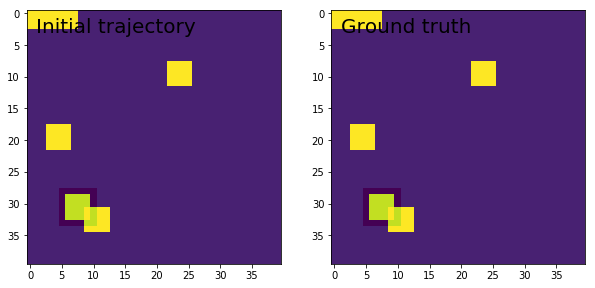

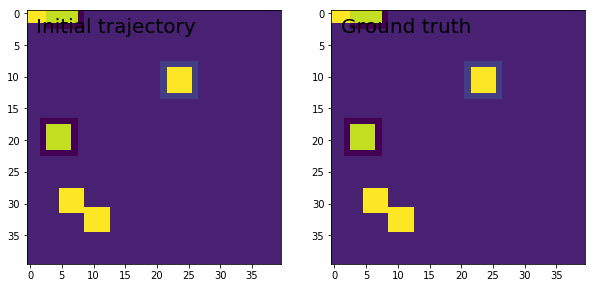

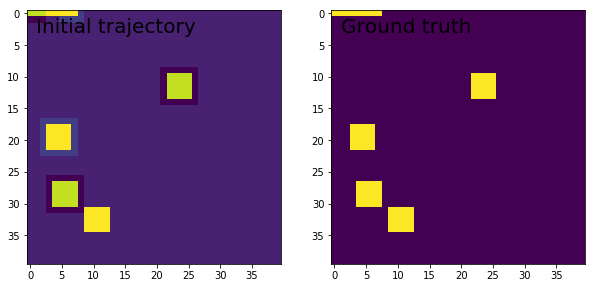

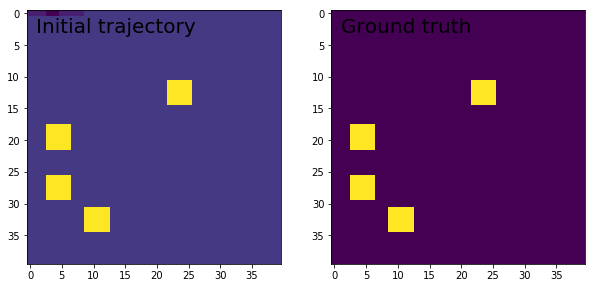

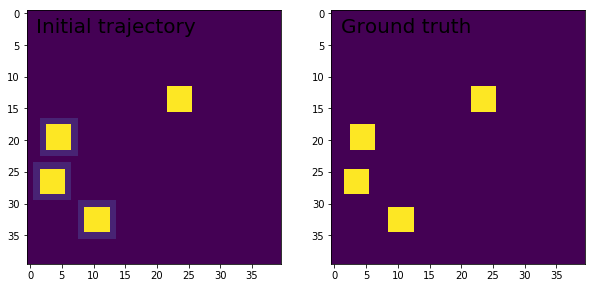

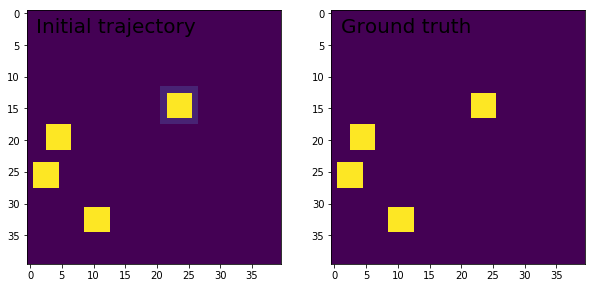

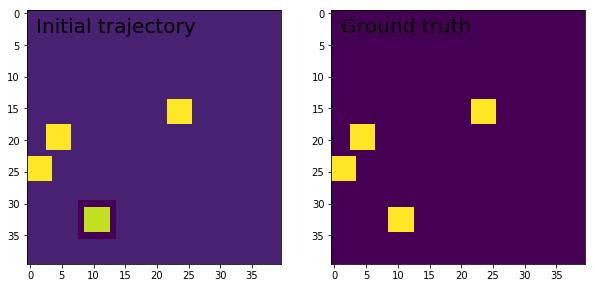

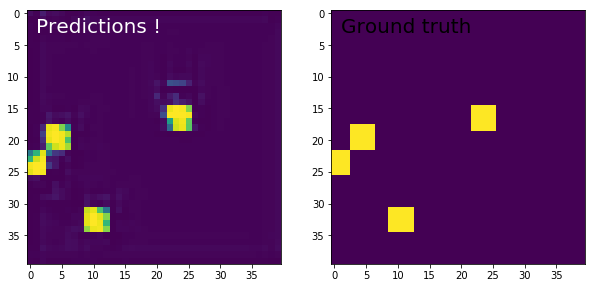

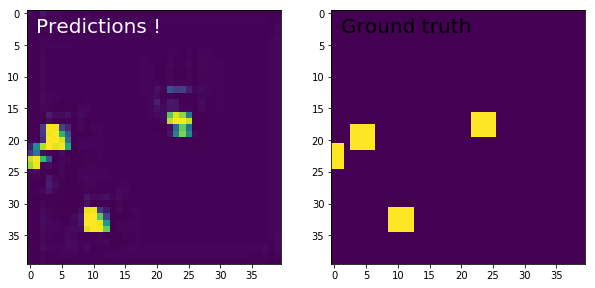

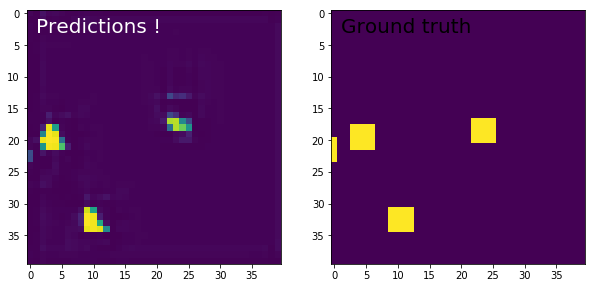

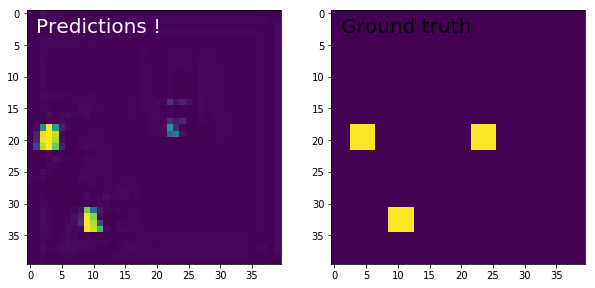

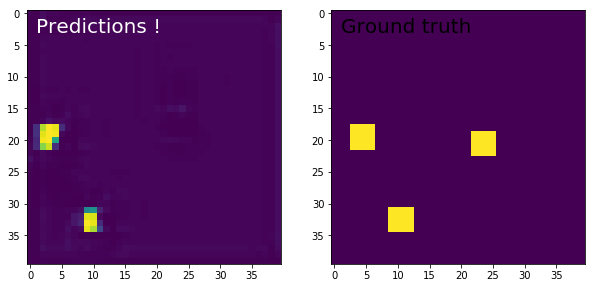

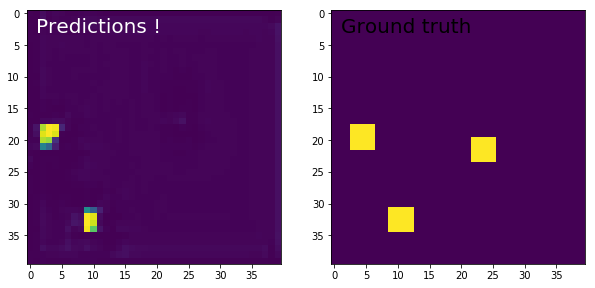

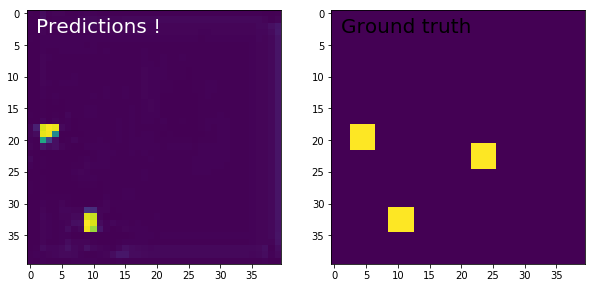

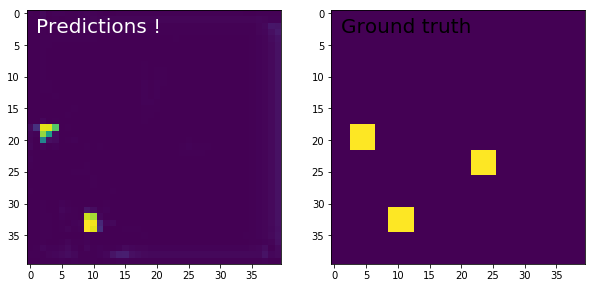

In [10]:
"""
#This script demonstrates the use of a convolutional LSTM network.
This network is used to predict the next frame of an artificially
generated movie which contains moving squares.
"""
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

start = time.time()

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')


# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=batch_size,
        epochs=n_epoch, validation_split=0.05)

# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)
    
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
time_dict['ConvLSTM2D'] = elapsed_time


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))

## SimpleRNNCell→LSTMのサンプルコードの書き換えで動作
### 環境
- SimpleRNNCellクラスのインスタンスを作成し、そのインスタンスをRNNレイヤの引数として使用

### サンプルコードからの変更箇所
- keras.layers.RNNクラス、LSTMCellクラスをインポート
```python
from keras.layers import RNN, SimpleRNNCell
```
- SimpleRNNCellのインスタンスを作成し、RNNレイヤの引数に指定
```python
cell = SimpleRNNCell(128, dropout=0.2, recurrent_dropout=0.2)
model.add(RNN(cell))
```

In [11]:
start = time.time()

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
cell = SimpleRNNCell(128, dropout=0.2, recurrent_dropout=0.2)
model.add(RNN(cell))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train[:100], y_train[:100],
          batch_size=batch_size,
          epochs=n_epoch,
          validation_data=(x_test[:100], y_test[:100]))
score, acc = model.evaluate(x_test[:100], y_test[:100],
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

test_acc_dict['SimpleRNNCell'] = acc
time_dict['SimpleRNNCell'] = elapsed_time

Build model...
Train...
Train on 100 samples, validate on 100 samples
Epoch 1/5
100/100 [==============================] - 2s 25ms/step - loss: 0.6815 - acc: 0.5800 - val_loss: 0.6945 - val_acc: 0.4800
Epoch 2/5
100/100 [==============================] - 1s 8ms/step - loss: 0.6718 - acc: 0.5800 - val_loss: 0.6972 - val_acc: 0.4800
Epoch 3/5
100/100 [==============================] - 1s 8ms/step - loss: 0.6600 - acc: 0.6000 - val_loss: 0.7286 - val_acc: 0.4800
Epoch 4/5
100/100 [==============================] - 1s 8ms/step - loss: 0.6558 - acc: 0.6200 - val_loss: 0.7890 - val_acc: 0.4900
Epoch 5/5
100/100 [==============================] - 0s 2ms/step
Test score: 0.70869100689888
Test accuracy: 0.4800000123679638
elapsed_time:6.552968502044678[sec]


## GRUCell
### 環境
- GRUCellクラスのインスタンスを作成し、そのインスタンスをRNNレイヤの引数として使用

### サンプルコードからの変更箇所
- keras.layers.RNNクラス、GRUCellクラスをインポート
```python
from keras.layers import RNN, GRUCell
```

- GRUCellのインスタンスを作成し、RNNレイヤの引数に指定
```python
cell = GRUCell(128, dropout=0.2, recurrent_dropout=0.2)
model.add(RNN(cell))
```

In [12]:
start = time.time()

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
cell = GRUCell(128, dropout=0.2, recurrent_dropout=0.2)
model.add(RNN(cell))
# model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train[:100], y_train[:100],
          batch_size=batch_size,
          epochs=n_epoch,
          validation_data=(x_test[:100], y_test[:100]))
score, acc = model.evaluate(x_test[:100], y_test[:100],
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

test_acc_dict['GRUCell'] = acc
time_dict['GRUCell'] = elapsed_time

Build model...
Train...
Train on 100 samples, validate on 100 samples
Epoch 1/5
100/100 [==============================] - 5s 45ms/step - loss: 0.6871 - acc: 0.5900 - val_loss: 0.6990 - val_acc: 0.4700
Epoch 2/5
100/100 [==============================] - 2s 24ms/step - loss: 0.6468 - acc: 0.5800 - val_loss: 0.7197 - val_acc: 0.4700
Epoch 3/5
100/100 [==============================] - 2s 24ms/step - loss: 0.4707 - acc: 0.7700 - val_loss: 0.6749 - val_acc: 0.5600
Epoch 4/5
100/100 [==============================] - 2s 24ms/step - loss: 0.1914 - acc: 0.9700 - val_loss: 0.6299 - val_acc: 0.7200
Epoch 5/5
100/100 [==============================] - 0s 4ms/step
Test score: 0.7879647172987461
Test accuracy: 0.5300000108778476
elapsed_time:15.92553997039795[sec]


## LSTMCell
### 環境
- LSTMCellクラスのインスタンスを作成し、そのインスタンスをRNNレイヤの引数として使用

### サンプルコードからの変更箇所
- keras.layers.RNNクラス、LSTMCellクラスをインポート
```python
from keras.layers import RNN, LSTMCell
```

- LSTMCellのインスタンスを作成し、RNNレイヤの引数に指定
```python
cell = LSTMCell(128, dropout=0.2, recurrent_dropout=0.2)
model.add(RNN(cell))
```

In [13]:
start = time.time()

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
cell = LSTMCell(128, dropout=0.2, recurrent_dropout=0.2)
model.add(RNN(cell))
# model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train[:100], y_train[:100],
          batch_size=batch_size,
          epochs=n_epoch,
          validation_data=(x_test[:100], y_test[:100]))
score, acc = model.evaluate(x_test[:100], y_test[:100],
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

test_acc_dict['LSTMCell'] = acc
time_dict['LSTMCell'] = elapsed_time

Build model...
Train...
Train on 100 samples, validate on 100 samples
Epoch 1/5
100/100 [==============================] - 6s 56ms/step - loss: 0.6900 - acc: 0.5400 - val_loss: 0.7003 - val_acc: 0.4700
Epoch 2/5
100/100 [==============================] - 3s 30ms/step - loss: 0.6552 - acc: 0.5900 - val_loss: 0.6966 - val_acc: 0.4700
Epoch 3/5
100/100 [==============================] - 3s 31ms/step - loss: 0.5717 - acc: 0.8400 - val_loss: 0.6838 - val_acc: 0.5300
Epoch 4/5
100/100 [==============================] - 3s 31ms/step - loss: 0.4235 - acc: 0.9600 - val_loss: 1.1060 - val_acc: 0.5700
Epoch 5/5
100/100 [==============================] - 1s 6ms/step
Test score: 0.6572196781635284
Test accuracy: 0.620000009983778
elapsed_time:20.114386320114136[sec]


## StackedRNNCells→LSTMのサンプルコードの書き換えで動作
### 環境
- SimpleRNNCellクラスの以下のインスタンスを3つ作成し、その3つのインスタンスを含むリストをRNNレイヤの引数として使用し、StackedRNNを作成し実行
```python
SimpleRNNCell(128, dropout=0.2, recurrent_dropout=0.2)
```

### サンプルコードからの変更箇所
- keras.layers.RNNクラス、SimpleRNNCellクラスをインポート
```python
from keras.layers import GRU
```

- SimpleRNNCellのインスタンスを作成し、リストを作成しRNNレイヤの引数に指定
```python
cell1 = SimpleRNNCell(128, dropout=0.2, recurrent_dropout=0.2)
cell2 = SimpleRNNCell(128, dropout=0.2, recurrent_dropout=0.2)
cell3 = SimpleRNNCell(128, dropout=0.2, recurrent_dropout=0.2)
cells = [cell1, cell2, cell3]
```


In [14]:
start = time.time()

start = time.time()
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
cell1 = SimpleRNNCell(128, dropout=0.2, recurrent_dropout=0.2)
cell2 = SimpleRNNCell(128, dropout=0.2, recurrent_dropout=0.2)
cell3 = SimpleRNNCell(128, dropout=0.2, recurrent_dropout=0.2)
cells = [cell1, cell2, cell3]
model.add(RNN(cells))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train[:100], y_train[:100],
          batch_size=batch_size,
          epochs=n_epoch,
          validation_data=(x_test[:100], y_test[:100]))
score, acc = model.evaluate(x_test[:100], y_test[:100],
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

test_acc_dict['StackedRNNCells'] = acc
time_dict['StackedRNNCells' ] = elapsed_time

Build model...
Train...
Train on 100 samples, validate on 100 samples
Epoch 1/5
100/100 [==============================] - 4s 43ms/step - loss: 0.7178 - acc: 0.5600 - val_loss: 0.8582 - val_acc: 0.4500
Epoch 2/5
100/100 [==============================] - 2s 17ms/step - loss: 0.7761 - acc: 0.5400 - val_loss: 1.0307 - val_acc: 0.4700
Epoch 3/5
100/100 [==============================] - 2s 17ms/step - loss: 0.7771 - acc: 0.5000 - val_loss: 0.8264 - val_acc: 0.4700
Epoch 4/5
100/100 [==============================] - 2s 17ms/step - loss: 0.8316 - acc: 0.4100 - val_loss: 0.6913 - val_acc: 0.5100
Epoch 5/5
100/100 [==============================] - 0s 3ms/step
Test score: 0.7112004369497299
Test accuracy: 0.5200000092387199
elapsed_time:12.687102794647217[sec]


## CuDNNGRU→LSTMのサンプルコードの書き換えで動作
### サンプルコードからの変更箇所
- keras.layers.CuDNNGRUクラスをインポート
```python
from keras.layers import CuDNNGRU
```

- 使用するレイヤーをGRUに変更
```python
model.add(CuDNNGRU(128, dropout=0.2, recurrent_dropout=0.2))
```

In [15]:
start = time.time()

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(CuDNNGRU(128))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train[:100], y_train[:100],
          batch_size=batch_size,
          epochs=5,
          validation_data=(x_test[:100], y_test[:100]))
score, acc = model.evaluate(x_test[:100], y_test[:100],
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

test_acc_dict['CuDNNGRU'] = acc
time_dict['CuDNNGRU'] = elapsed_time

Build model...
Train...
Train on 100 samples, validate on 100 samples
Epoch 1/5
100/100 [==============================] - 3s 27ms/step - loss: 0.6908 - acc: 0.5700 - val_loss: 0.6965 - val_acc: 0.4700
Epoch 2/5
100/100 [==============================] - 0s 3ms/step - loss: 0.6389 - acc: 0.6500 - val_loss: 0.7137 - val_acc: 0.4700
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.3584 - acc: 0.8100 - val_loss: 0.7151 - val_acc: 0.5700
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.1982 - acc: 0.9700 - val_loss: 0.8574 - val_acc: 0.5300
Epoch 5/5
100/100 [==============================] - 0s 678us/step
Test score: 1.0796114757657052
Test accuracy: 0.5100000135600566
elapsed_time:6.7020463943481445[sec]


## CuDNNLSTM→LSTMのサンプルコードの書き換えで動作
### サンプルコードからの変更箇所
- keras.layers.CuDNNLSTMクラスをインポート
```python
from keras.layers import CuDNNLSTM
```

- 使用するレイヤーをCuDNNLSTMに変更
```python
model.add(CuDNNLSTM(128, dropout=0.2, recurrent_dropout=0.2))
```

In [16]:
start = time.time()

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train[:100], y_train[:100],
          batch_size=batch_size,
          epochs=n_epoch,
          validation_data=(x_test[:100], y_test[:100]))
score, acc = model.evaluate(x_test[:100], y_test[:100],
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

test_acc_dict['CuDNNLSTM'] = acc
time_dict['CuDNNLSTM'] = elapsed_time

Build model...
Train...
Train on 100 samples, validate on 100 samples
Epoch 1/5
100/100 [==============================] - 3s 28ms/step - loss: 0.6867 - acc: 0.5700 - val_loss: 0.7155 - val_acc: 0.4700
Epoch 2/5
100/100 [==============================] - 0s 3ms/step - loss: 0.6371 - acc: 0.6600 - val_loss: 0.6902 - val_acc: 0.5500
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.4714 - acc: 0.9400 - val_loss: 0.6819 - val_acc: 0.5400
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.2288 - acc: 0.9600 - val_loss: 0.6931 - val_acc: 0.5800
Epoch 5/5
100/100 [==============================] - 0s 697us/step
Test score: 0.7130492150783538
Test accuracy: 0.6600000090897084
elapsed_time:4.542067527770996[sec]


# 【問題2】比較結果の説明
11の項目それぞれがどういうものなのかを説明してください。また、比較した結果を表やグラフで載せ、説明してください。今回は「RNNはそれほど詳しくないがタスクで必要になったためKerasのドキュメントを見た」という仮定を置きます。

- RNN
- SimpleRNN
- GRU
- LSTM
- ConvLSTM2D
- SimpleRNNCell
- GRUCell
- LSTMCell
- StackedRNNCells
- CuDNNGRU
- CuDNNLSTM

## 精度比較

### 全モデルのスコア

In [25]:
pd.DataFrame(test_acc_dict.items(), columns=['model name', 'Accuracy'])

,model name,Accuracy
0,RNN,0.45
1,SimpleRNN,0.55
2,GRU,0.63
3,SimpleRNNCell,0.48
4,GRUCell,0.53
5,LSTMCell,0.62
6,StackedRNNCells,0.52
7,CuDNNGRU,0.51
8,CuDNNLSTM,0.66


### 棒グラフにて比較

In [21]:
acc_np = np.array(list(test_acc_dict.values()))
acc_np

array([0.45000001, 0.55000002, 0.63000001, 0.48000001, 0.53000001,
       0.62000001, 0.52000001, 0.51000001, 0.66000001])

In [22]:
len(acc_np)

9

In [23]:
acc_label = np.array(list(test_acc_dict.keys()))
acc_label

array(['RNN', 'SimpleRNN', 'GRU', 'SimpleRNNCell', 'GRUCell', 'LSTMCell',
       'StackedRNNCells', 'CuDNNGRU', 'CuDNNLSTM'], dtype='<U15')

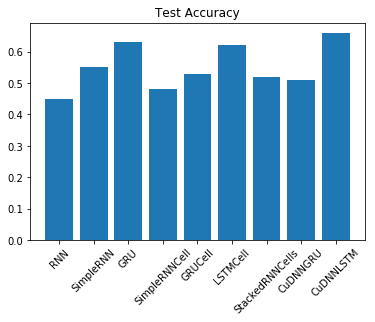

In [24]:
fig, ax = plt.subplots()
ax.bar(range(len(acc_np)), acc_np, tick_label=acc_label)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=10);
plt.title('Test Accuracy');

## 考察
### CuDNNLSTMを利用したモデルが最も高い精度となった
- その次にGRU、LSTMCellの順に高い精度となる事を確認し、各モデルの中でもRNNをベースとしたモデルが高い精度となる傾向を確認。

## 各モデルの概要

## RNN
- Recurrentレイヤーに対する基底クラス(スーパクラス)
- [kerasのページ](https://keras.io/ja/layers/recurrent/#rnn)



## SimpleRNN
- 出力が入力にフィードバックされる全結合RNNクラス
- [kerasのページ](https://keras.io/ja/layers/recurrent/#gru)

## GRU(Gated Recurrent Unit)
- ゲート付きRNNクラス
- [kerasのページ](https://keras.io/ja/layers/recurrent/#gru)

## LSTM
- LSTMクラス
- [kerasのページ](https://keras.io/ja/layers/recurrent/#lstm)

## ConvLSTM2D
- LSTMの入力変換と再帰変換が畳み込み演算となるユニット


## SimpleRNNCell
- SimpleRNNのCellクラス

- [kerasのページ](https://keras.io/ja/layers/recurrent/#simplernncell)

## GRUCell
- GRUレイヤのCellクラス
- [kerasのページ](https://keras.io/ja/layers/recurrent/#grucell)

## LSTMCell
- LSTMレイヤのCellクラス
- [kerasのページ](https://keras.io/ja/layers/recurrent/#lstmcell)

## StackedRNNCells
- RNN cellを複数繋げて実行させるためのラッパー
- [kerasのページ](https://keras.io/ja/layers/recurrent/#stackedrnncells)

## CuDNNGRU
- CuDNNを利用したGRU実装
- GPUを使用可能な為、通常のCPUを用いて行うGRUセルと比較し高速な動作が可能となる　
- [kerasのページ](https://keras.io/ja/layers/recurrent/#cudnngru)

## CuDNNLSTM
- CuDNNを利用したLSTM実装
- GPUを使用可能な為、通常のCPUを用いて行うGRUセルと比較し高速な動作が可能となる　
- [kerasのページ](https://keras.io/ja/layers/recurrent/#cudnnlstm)

# 【問題3】（アドバンス課題）複数のデータセット間での比較
単一のデータセットでの実験に留めず、他のデータセットでも実験してみます。

[データセット - Keras Documentation](https://keras.io/ja/datasets/#_5)

Kerasで簡単に利用できる自然言語データセットとしてロイターのニュースワイヤー トピックス分類があります。IMDBは2値分類であったが、こちらは46値分類の問題です。